# Initial Data Analysis

In [1]:
# Helper libraries
import warnings

# Scientific and visual libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Local Modules
from youtube_analysis.edautils import get_dataset_info, plot_stem

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

In [2]:
from youtube_analysis.paths import RAW_DATA_DIR, INTERIM_DATA_DIR

Now it is time to take a look at the data. In this step we are going to take a look at different aspects. There is no substitute for it in order to plant seeds that may later grow into ideas on how to better pre-process.

Before we will make a copy of the original data to avoid unfortunate modifications:

In [3]:
data = pd.read_pickle(RAW_DATA_DIR / "lex_comments.pkl")
corpus = data.copy()
corpus.head(10)

,author,published_at,updated_at,likes,text
0,Lex Fridman,2022-12-29T17:34:04Z,2022-12-29T17:34:04Z,194,Here are the timestamps. Please chec...
1,John Dickinson,2023-11-19T10:59:46Z,2023-11-19T10:59:46Z,0,Protein research is a major new brea...
2,John Dickinson,2023-11-19T10:50:38Z,2023-11-19T10:50:38Z,0,This is a good one.
3,john g henderson,2023-11-18T03:47:08Z,2023-11-18T03:49:31Z,0,A very interesting conversation unti...
4,arife dickerson,2023-11-17T20:49:24Z,2023-11-17T20:49:24Z,0,This chick is always in Bilderberg g...
5,WakeUpnThinkClearly,2023-11-17T18:51:44Z,2023-11-17T18:51:44Z,0,Now I feel really infinitely ignoran...
6,Mike Huff,2023-11-17T01:54:59Z,2023-11-17T01:56:52Z,0,I kept checking the time in hopes th...
7,Steve C,2023-11-10T22:16:58Z,2023-11-10T22:16:58Z,0,😳The Plants are Fake…?
8,Brigid Mary Prain,2023-11-09T09:51:33Z,2023-11-09T09:51:33Z,0,Responding to your pushback on the p...
9,Jack Reacher,2023-11-04T09:30:38Z,2023-11-04T09:30:38Z,0,"<a href=""https://www.youtube.com/wat..."


I'm going to use the function `get_dataset_info`, that does everything I need for that. The entire implementation can be found [here](https://github.com/abljoel/youtube-comments-analysis/blob/main/src/youtube_analysis/edautils.py).

In [4]:
get_dataset_info(corpus)

Dataset dimensions: 2051 rows and 5 columns
-----------------------------------
Attribute set:
['author', 'published_at', 'updated_at', 'likes', 'text']
-----------------------------------
Data types:
author          object
published_at    object
updated_at      object
likes            int64
text            object
dtype: object
-----------------------------------
Cardinality in variables:
likes             56
author          1705
text            2042
published_at    2047
updated_at      2047
dtype: int64
-----------------------------------
Values in variables:
author -> APTERA EVoL-eR Dave Pyne Keely Evans adelina quijano miriam kucera ...
published_at -> 2022-12-29T17:34:04Z 2022-12-29T22:05:53Z 2022-12-30T01:36:52Z 2022-12-31T12:01:58Z 2023-01-01T14:04:36Z ...
updated_at -> 2022-12-29T17:34:04Z 2022-12-29T22:05:53Z 2022-12-30T01:36:52Z 2022-12-31T12:01:58Z 2023-01-01T14:04:36Z ...
likes -> 0 1 2 3 4 ...
text -> Every interview is amazing, but this conversation was on another level.  

With very little code, we already have a lot of information. All units of observation are unique. We don't get missing values. You can see that the dataset has 2051 observations and 5 attributes. One attribute (likes) has less unique values than the others, it is also the only numeric variable, and values in columns confirm it. However there is ambiguity in object typed variables that subject expertise and variable names can resolve: there are two datetime variables (published_at and updated_at), one text-based variable (text), and one nominal variable (author).

Variables of interest for us are: likes, text, published_at. The variable `likes` is well typed. Since we will need to manipulate the time-dependent variables, we must recast them:

In [5]:
corpus.published_at = pd.to_datetime(corpus.published_at)
corpus.updated_at = pd.to_datetime(corpus.updated_at)

We can take advantage of this to recast the variable `text`:

In [6]:
corpus.text = corpus.text.astype("string")

Now we get:

In [7]:
corpus.dtypes

author                       object
published_at    datetime64[ns, UTC]
updated_at      datetime64[ns, UTC]
likes                         int64
text                 string[python]
dtype: object

Now it’s important to inspect ranges in the data to know whether there are any errors that would distort the analysis, because data scraping could go wrong.

We know that this video was first published the 29 december 2022 and is still online:

In [8]:
## Variable classification

count_variable = [
    "likes",
]

datetime_variables = [
    "published_at",
    "updated_at",
]

corpus[datetime_variables].describe()

,published_at,updated_at
count,2051,2051
mean,2023-01-30 02:11:16.174061312+00:00,2023-01-30 03:29:25.087761920+00:00
min,2022-12-29 17:34:04+00:00,2022-12-29 17:34:04+00:00
25%,2022-12-30 11:14:12.500000+00:00,2022-12-30 12:20:40+00:00
50%,2023-01-03 13:55:48+00:00,2023-01-03 14:56:13+00:00
75%,2023-01-26 07:47:53+00:00,2023-01-26 09:44:49.500000+00:00
max,2023-11-19 10:59:46+00:00,2023-11-19 10:59:46+00:00


We can get our first quick and dirty insight in advance based on these data:

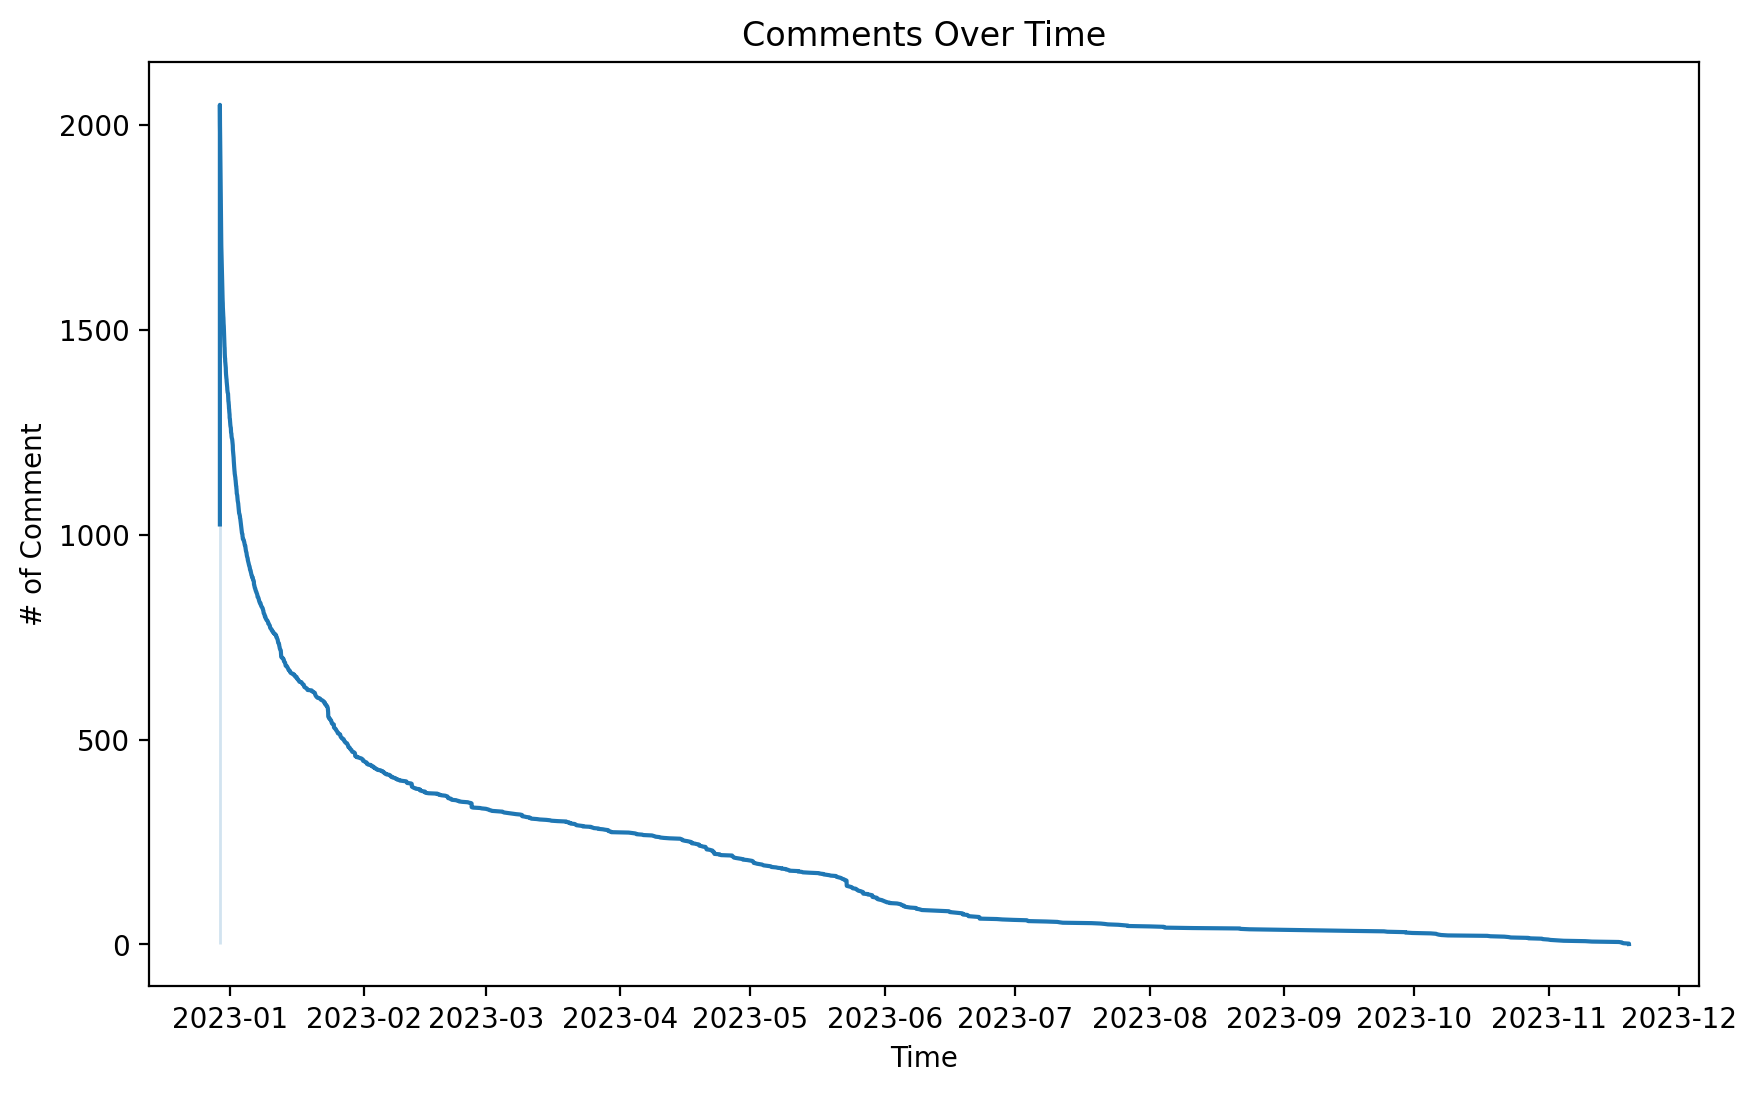

In [9]:
plt.figure(figsize=(10, 6))
plt.title("Comments Over Time")
sns.lineplot(data=corpus[datetime_variables], 
             y=corpus[datetime_variables].index, 
             x="published_at")
plt.xlabel("Time")
plt.ylabel("# of Comment")
plt.show()

As we can see, the number of comments is high at the beginning and decrease over time, like on most engagement on social medias.

Now let’s look at like counts:

In [10]:
## Check Range values in like count variable:
corpus[count_variable].describe()

,likes
count,2051.0000
mean,2.8337
std,18.3585
min,0.0000
25%,0.0000
50%,0.0000
75%,1.0000
max,369.0000


All we can guess here is that there is an asymmetry between viewers in term of likes (more than 75% have almost no likes), and there are some that have 368 likes. We know that on social media, viewers with high like count are infrequent and conversly low like count as very common. Te better see this phenomenon we can plot like counts:

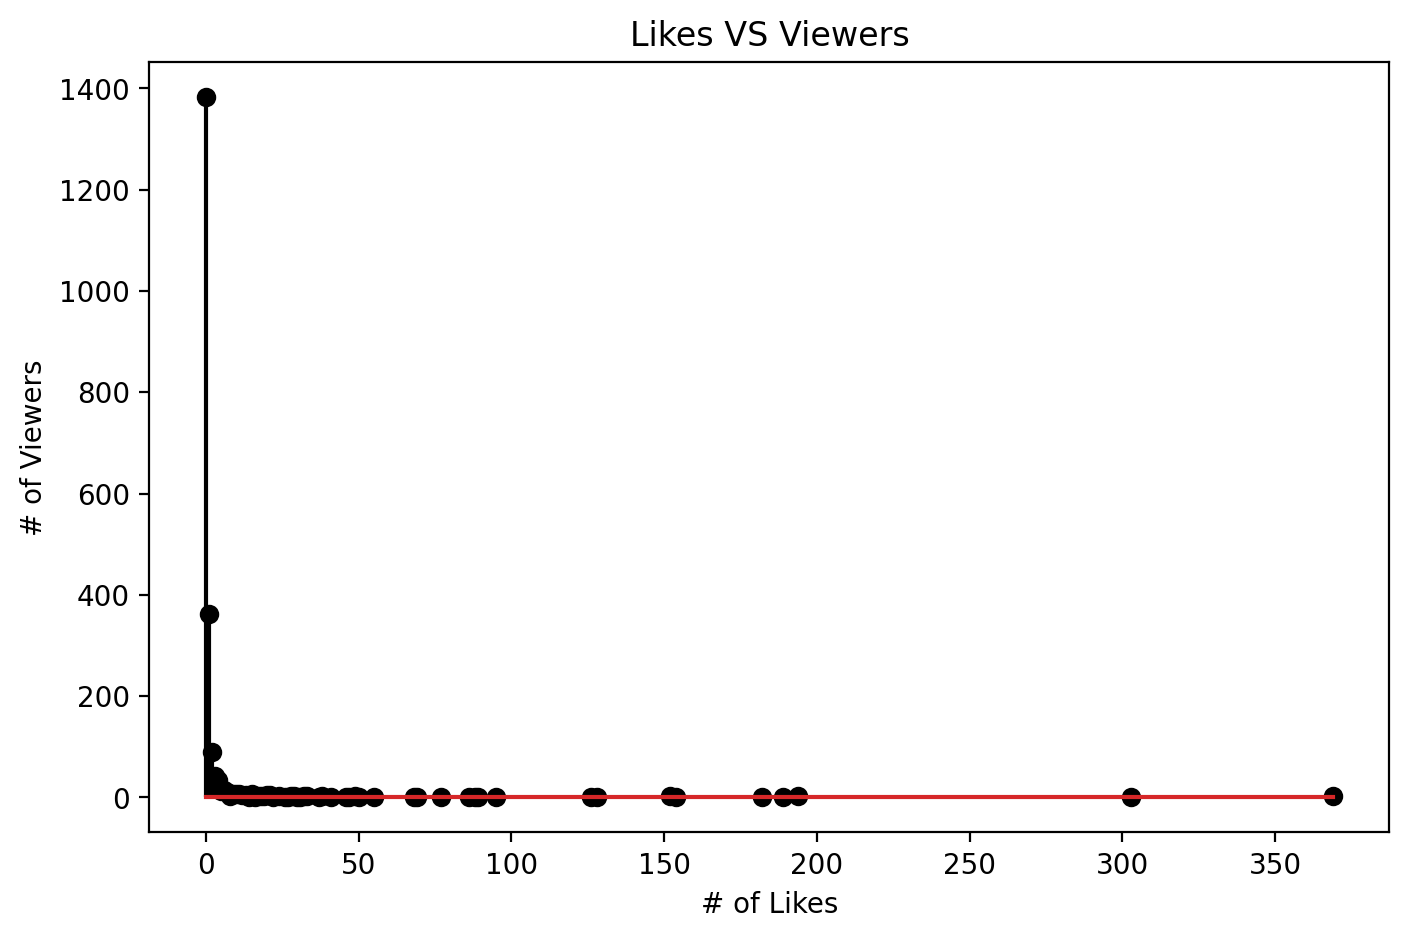

In [11]:
plt.figure(figsize=(8, 5))
plt.xlabel("# of Likes")
plt.ylabel("# of Viewers")
plot_stem(corpus, "likes", "Likes VS Viewers")

Finally Let’s check what kind of garbage and inconsistency we have in initial text corpus. We will review a sample rather than all data:

In [12]:
for i in range(10):
    sample = corpus.sample(n=10, random_state=i)
    for text in sample.text:
        print(text)
        print("---------------------------------------------------------------------------")

1:24:40 "that's the ultimate gift we can give back to the entire species on this planet" wow there's something about the way she delivered that line that hit me so hard, im somehow vicariously passionate about the origins of life and aslo the future of mankind now
---------------------------------------------------------------------------
This was mind-blowingly fascinating.
---------------------------------------------------------------------------
they so hooked up after this lol
---------------------------------------------------------------------------
What a lovely lady!
---------------------------------------------------------------------------
Lex hurt his neck on that intro
---------------------------------------------------------------------------
😍
---------------------------------------------------------------------------
Eukaryote: any cell or organism that possesses a clearly defined nucleus. The eukaryotic cell has a nuclear membrane that surrounds the nucleus, in which t

After having eyeballed the samples (and the header of the corpus), we finally understand that we will have to deal with:
- Capitalization,
- Punctuation,
- Special characters,
- Numbers,
- Urls/Html tags,
- Emojis/emoticons,
- Misspelling,
- Foreign characters/words,
- and so on.

The actual dataset, which is no more the raw data, is an intermediate form which will require preprocessing: this is why I put it in the `interim` directory:

In [13]:
corpus.to_pickle(INTERIM_DATA_DIR / "corpus.pkl")